In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, model_selection, preprocessing, pipeline, impute, feature_selection
from sklearn.experimental import enable_iterative_imputer
from itertools import chain, combinations, product
import math
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

%matplotlib inline
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

import networkx as nx
import graphviz

In [2]:
# Constants
EPSILON = 0.001

In [3]:
data = pd.read_csv("insurance.csv")
data

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,Accident,MakeModel,DrivQuality,...,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
0,False,Adult,Prole,Adventurous,Older,Moderate,EggShell,Mild,Economy,Poor,...,City,False,TenThou,Thousand,True,Thousand,Poor,False,Thousand,Many
1,False,Senior,Prole,Cautious,Current,None,Football,None,Economy,Normal,...,City,True,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero
2,False,Senior,UpperMiddle,Psychopath,Current,None,Football,None,FamilySedan,Excellent,...,City,False,Thousand,Thousand,False,Thousand,Good,True,Thousand,One
3,False,Adolescent,Middle,Normal,Older,None,EggShell,None,Economy,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Zero
4,False,Adolescent,Prole,Normal,Older,Moderate,Football,Moderate,Economy,Poor,...,City,False,TenThou,Thousand,False,Thousand,Fair,False,Thousand,Many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,Adult,Prole,Adventurous,Older,Mild,Football,Mild,Economy,Poor,...,City,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Many
19996,False,Adult,Middle,Normal,Older,None,Tank,None,FamilySedan,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,False,Thousand,Zero
19997,False,Senior,UpperMiddle,Normal,Current,None,Football,None,Luxury,Excellent,...,Secure,True,TenThou,Thousand,False,Thousand,Excellent,True,Thousand,Zero
19998,False,Adult,Middle,Normal,Older,None,Football,None,FamilySedan,Excellent,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero


In [4]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = data[data.columns.drop("Accident")]
y = data["Accident"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [5]:
app = X_train.copy()
app["Accident"] = y_train

learner=gum.BNLearner(app)

bn = learner.learnBN()

bn=learner.useGreedyHillClimbing().useScoreK2().learnBN()


In [6]:
gnb.flow.add(gnb.getBN(bn,size="20"))
gnb.flow.display()

In [7]:
acc = 0
domain = sorted(np.unique(y_train.to_numpy()))
for i in X_test.index :
    ie=gum.LazyPropagation(bn)
    ie.addTarget("Accident")
    instance = X_test.loc[i]
    for j in X_test.columns :
        ie.addEvidence(j,str(instance[j]))
    ie.makeInference()
    post = ie.posterior("Accident")
    #print(post)
    #print(y_test.loc[i])
    acc = acc + post[domain.index(y_test.loc[i])]
print(acc / len(X_test.index))

0.9243982133352232


In [8]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))

True

In [9]:
bn.nodeset(["OtherCarCost"])

<Swig Object of type 'gum::NodeSet *' at 0x7ff908188cc0>

In [10]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.setEvidence({"RiskAversion" : "Psychopath", "Accident" : "None"})
ie.evidenceProbability()
#print(ie.posterior(bn.idFromName("Accident")))


0.008121411707371675

In [11]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.addJointTarget(set(["Accident", "RiskAversion"]))
#ie.setEvidence({"RiskAversion" : "Psychopath"})
#ie.evidenceProbability()
print(ie.jointPosterior(set(["Accident", "RiskAversion"])))


      ||  Accident                             |
RiskAv||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Advent|| 0.0319  | 0.0277  | 0.1637  | 0.0442  |
Cautio|| 0.0155  | 0.0124  | 0.1916  | 0.0186  |
Normal|| 0.0400  | 0.0329  | 0.3560  | 0.0504  |
Psycho|| 0.0021  | 0.0019  | 0.0081  | 0.0030  |



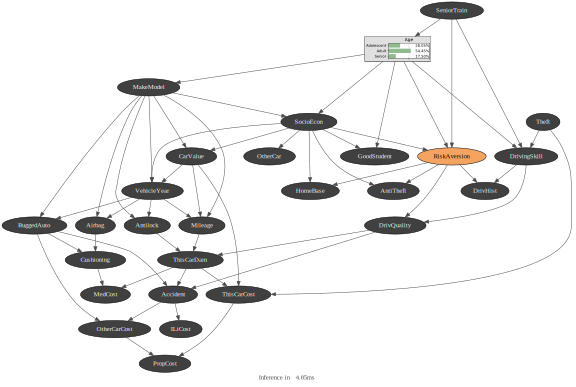

In [12]:
res = gnb.showInference(model = bn, engine = gum.LazyPropagation(bn), evs = {"RiskAversion" : "Psychopath"}, targets = ["Age"], view = "graph")


In [13]:
#bn.cpt(1).variable(1).domain()

bn.variableFromName("Age").labels()

('Adolescent', 'Adult', 'Senior')

In [14]:
ie=gum.LazyPropagation(bn)
#ie.makeInference()
ie.addEvidence("RiskAversion","Cautious")
ie.addJointTarget(set(["Accident", "ILiCost"]))
print(ie.jointPosterior(set(["Accident", "ILiCost"])))


      ||  Accident                             |
ILiCos||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Hundre|| 0.0000  | 0.0019  | 0.0001  | 0.0043  |
Millio|| 0.0000  | 0.0012  | 0.0001  | 0.0041  |
TenTho|| 0.0001  | 0.0029  | 0.0001  | 0.0075  |
Thousa|| 0.0648  | 0.0461  | 0.8045  | 0.0623  |



In [15]:
l = np.unique(y_train.to_numpy())
print(sorted(l))

['Mild', 'Moderate', 'None', 'Severe']


In [16]:
def powerset(iterable):
    s = list(iterable)
    tmp = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    return tmp

In [17]:
def omega(variable, data) :
    return list(data[variable].unique())

In [18]:
omega("Age",X)

['Adult', 'Senior', 'Adolescent']

In [19]:
def reduce_dataset(instance, X,y) :
    columns = X.columns
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            X = X[X[columns[i]] == value]
            X = X.drop(columns[i], axis=1)
    y = y[[j for j in y.index if j in X.index]]
    return X,y

In [53]:
def list_diff(list1, list2) :
    diff = []
    for i in list1 :
        if i not in list2 :
            diff.append(i)
    return diff

def prune_network(bn, ev_vars, hyp_vars, supp_vars = None) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def map_query(bn, ev_vars, hyp_vars) :
    return propagate_evidence(bn, ev_vars, joint_targets = [hyp_vars]).jointPosterior(set(hyp_vars))


def propagate_evidence(bn, ev_vars, joint_targets = []) :
    ie=gum.LazyPropagation(bn)
    for i in joint_targets :
        ie.addJointTarget(set(i))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    return ie
            
    
def omega(variables, data = None , bn = None) :
    domains = []
    if bn is not None :
        for variable in variables :
            domains.append(sorted(bn.variableFromName(variable).labels()))
    else :
        for variable in variables :
            domains.append(sorted(data[variable].unique()))
    return [p for p in product(*domains)]
    

def prepare_mapi(instances, variables) :
     #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    evidence_set = []
    # For each instance:
    for instance in instances :
        # Check which are the evidence variables
        evidence = dict()
        for i,value in enumerate(instance) :
            if isinstance(value, str) or not math.isnan(value) :
                evidence[variables[i]] = value
        evidence_set.append(evidence)
    return evidence_set
    

# True if R is relevant/MAP-dependent
# False if R is irrelevant/MAP-independent
def map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    # Check which are the supplementary (missing) variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
    # Check if R in unobserved
    #print(supp_vars)
    for R in set_R :
        if R not in supp_vars :
            print("Error, the variables", R, "is in the set R but is not a supplementary node")
            return
    y = hyp_vars_assign
    if y is None :    
        # Perform a MAP-query and get the argmax from the posterior
        posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
        y = posterior.argmax()[0][0]
    # Obtain domain of R
    omega_R = omega(set_R, bn = bn)
    # For each value assignment r in omega(R)
    for value_assignment_r in omega_R :
        # Fill in values
        ev_vars_alt = ev_vars.copy()
        for i,value in enumerate(value_assignment_r) :
            ev_vars_alt[set_R[i]] = value
        #print(instance)
        #print(instance_alt)
        # Inference with evidence and r
        posterior_alt = map_query(bn, ev_vars = ev_vars_alt, hyp_vars = hyp_vars)
        y_alt = posterior_alt.argmax()[0][0]
        # Comparar con prediccion de instance
        print(value_assignment_r)
        print(y, " == ", y_alt)
        #print(posterior.argmax()[1], "--", posterior_alt.argmax()[1])
        if y != y_alt :
            return True
    return False
    
def map_independence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    return not map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign)

In [21]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))
bn_pr = prune_network(bn, ["DrivingSkill", "RiskAversion"], ["DrivHist"])
#bn_pr.names()

swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python dete

In [22]:
map_query(bn, ev_vars = {'RiskAversion':"Psychopath"}, hyp_vars = ["Accident"]).argmax()[0][0]

{'Accident': 2}

In [23]:
map_independence(bn, ["ILiCost"], {'RiskAversion':"Psychopath"}, ["Accident"])

('HundredThou',)
{'Accident': 2}  ==  {'Accident': 3}


False

In [24]:
omega(["RiskAversion", "DrivingSkill"], bn = bn)

[('Adventurous', 'Expert'),
 ('Adventurous', 'Normal'),
 ('Adventurous', 'SubStandard'),
 ('Cautious', 'Expert'),
 ('Cautious', 'Normal'),
 ('Cautious', 'SubStandard'),
 ('Normal', 'Expert'),
 ('Normal', 'Normal'),
 ('Normal', 'SubStandard'),
 ('Psychopath', 'Expert'),
 ('Psychopath', 'Normal'),
 ('Psychopath', 'SubStandard')]

In [25]:
def check_every_r_bn(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_nodes = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_nodes)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_nodes :
            supp_vars.append(i)
    
    S = powerset(supp_vars)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        if i < depth :
            for j in S_split[i] :
                # If relevant
                print(list(j))
                if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                    relevant_sets.append(j)
                    # Apply prune
                    for k in range(i+1,len(S_split)) :
                        tmp = []
                        for l in S_split[k] :
                            if set(j).issubset(set(l)) :
                                relevant_sets.append(l)
                            else :
                                tmp.append(l)
                        S_split[k] = tmp
                # If irrelevant
                else :
                    irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_nodes

In [56]:
def get_c_exp(bn, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    print(hyp_vars_assign)
    if hyp_vars_assign is None :
        posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
        hyp_vars_assign = posterior.argmax()[0][0]
    
    # Alternative. First compute P(H|e) and then P(e) and compute the product
    ie=gum.LazyPropagation(bn)
    ie.addJointTarget(set(hyp_vars))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    post = ie.jointPosterior(set(hyp_vars))

    # Compute P(e)
    ie=gum.LazyPropagation(bn)
    ie.setEvidence(ev_vars)
    ie.makeInference()
    p_e = ie.evidenceProbability()
    
    post = post * p_e
    inst = gum.Instantiation(post)
    inst.fromdict(hyp_vars_assign)
    P_eh = post.get(inst)
    return post/P_eh

def decomposition_prune(relevant_set, S_split, relevant_sets) :
    i = len(relevant_set)
    for k in range(i,len(S_split)) :
        tmp = []
        for l in S_split[k] :
            if set(relevant_set).issubset(set(l)) :
                relevant_sets.append(l)
            else :
                tmp.append(l)
        S_split[k] = tmp
    return S_split, relevant_sets

def check_every_r_silja(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_nodes = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_nodes)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_nodes :
            supp_vars.append(i)
    
    S = powerset(supp_vars)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn_pr, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
        
    for i in range(0,len(S_split)) :
        if i < depth :
            if i == 0 :
                c_exp = get_c_exp(bn_pr, ev_vars, hyp_vars, hyp_vars_assign = y)
                inst_c = gum.Instantiation(c_exp)
                #ie_max=gum.LazyPropagation(bn_pr)
                #to_prop = ev_vars.copy()
                #to_prop.update(y)
                #ie_max.setEvidence(to_prop)
                #ie_max.makeInference()
                
                to_prop = ev_vars.copy()
                to_prop.update(y)
                ie_max = propagate_evidence(bn_pr, to_prop)
                
                relevant_singletons = []
                for j in S_split[0] :
                    # If relevant
                    if ie_max.posterior(j[0]).argmin()[1] == 0 :
                        relevant_sets.append(j)
                        relevant_singletons.append(j)
                        # Apply prune
                        S_split, relevant_sets = decomposition_prune(j, S_split, relevant_sets)
                S_split[0] = list_diff(S_split[0], relevant_singletons)
                
                print(S_split[0])

                omega_h = omega(hyp_vars, bn = bn_pr)
            
                print(omega_h)
                print(y)
                print(c_exp)
                if len(S_split[0]) > 0 :
                    for h_i in omega_h :
                        ie=gum.LazyPropagation(bn_pr)
                        to_prop = ev_vars.copy()
                        to_prop.update(dict(zip(hyp_vars, list(h_i))))
                        inst_c.fromdict(to_prop)
                        c_i = math.log(c_exp.get(inst_c))
                        ie.setEvidence(to_prop)
                        ie.makeInference()
                        tmp = S_split[0]
                        relevant_singletons = []
                        for j in S_split[0] :
                            post_max = ie_max.posterior(j[0])
                            post = ie.posterior(j[0])
                            inst_h = gum.Instantiation(post)
                            while not inst_h.end() and not math.log(post.get(inst_h) / post_max.get(inst_h)) + c_i > 0 :
                                inst_h.inc()
                            if not inst_h.end() :
                                relevant_sets.append(j)
                                relevant_singletons.append(j)
                                # Apply prune
                                S_split, relevant_sets = decomposition_prune(j, S_split, relevant_sets) 
                        print(S_split[0])
                        print(relevant_singletons)
                        S_split[0] = list_diff(S_split[0], relevant_singletons)
                        print(S_split[0])
                    
                    for j in S_split[0] :
                        irrelevant_sets.append(j)
                        
            else : 
                for j in S_split[i] :
                    # If relevant
                    print(list(j))
                    if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                        relevant_sets.append(j)
                        # Apply prune
                        S_split, relevant_sets = decomposition_prune(j, S_split, relevant_sets)
                    # If irrelevant
                    else :
                        irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_nodes

In [27]:
ev_vars = {'RiskAversion':"Psychopath"}
hyp_vars = ["Accident", "ILiCost", "Age"]
joint_target = list(ev_vars.keys()) + hyp_vars
#joint_target = sorted(joint_target)
ie=gum.LazyPropagation(bn)
#joint_target = ["Accident", "ILiCost", "RiskAversion"]
ie.addJointTarget(set(joint_target))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(joint_target))

In [28]:
get_c_exp(bn, ev_vars, hyp_vars)

None


(pyAgrum.Potential<double>@0x1d0f080) 
             ||  Accident                             |
Age   |ILiCos||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Adoles|Hundre|| 0.0001  | 0.0046  | 0.0000  | 0.0112  |
Adult |Hundre|| 0.0002  | 0.0077  | 0.0001  | 0.0184  |
Senior|Hundre|| 0.0001  | 0.0026  | 0.0000  | 0.0060  |
Adoles|Millio|| 0.0001  | 0.0029  | 0.0000  | 0.0107  |
Adult |Millio|| 0.0002  | 0.0048  | 0.0001  | 0.0177  |
Senior|Millio|| 0.0001  | 0.0016  | 0.0000  | 0.0058  |
Adoles|TenTho|| 0.0002  | 0.0071  | 0.0000  | 0.0197  |
Adult |TenTho|| 0.0004  | 0.0118  | 0.0001  | 0.0324  |
Senior|TenTho|| 0.0001  | 0.0039  | 0.0000  | 0.0106  |
Adoles|Thousa|| 0.1432  | 0.1120  | 0.4462  | 0.1642  |
Adult |Thousa|| 0.2398  | 0.1861  | 1.0000  | 0.2704  |
Senior|Thousa|| 0.0812  | 0.0623  | 0.3122  | 0.0886  |

In [29]:
# Alternative. First compute P(H|e) and then P(e) and compute the product
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(hyp_vars))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(hyp_vars))

# Compute P(e)
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(ev_vars.keys()))
ie.makeInference()
p_e = ie.jointPosterior(set(ev_vars.keys()))
inst_e = gum.Instantiation(p_e)
inst_e.fromdict(ev_vars)

post = post * p_e.get(inst_e)


In [30]:
print(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Millio|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Thousa|Adoles|| 0.0007  | 0.0005  | 0.0021  | 0.0008  |
Hundre|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Millio|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
TenTho|Adult || 0.0000  | 0.0001  | 0.0000  | 0.0001  |
Thousa|Adult || 0.0011  | 0.0009  | 0.0046  | 0.0012  |
Hundre|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Millio|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Thousa|Senior|| 0.0004  | 0.0003  | 0.0014  | 0.0004  |



In [31]:
c_exp = post/post.argmax()[1]
print(c_exp)
inst = gum.Instantiation(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0001  | 0.0046  | 0.0000  | 0.0112  |
Millio|Adoles|| 0.0001  | 0.0029  | 0.0000  | 0.0107  |
TenTho|Adoles|| 0.0002  | 0.0071  | 0.0000  | 0.0197  |
Thousa|Adoles|| 0.1432  | 0.1120  | 0.4462  | 0.1642  |
Hundre|Adult || 0.0002  | 0.0077  | 0.0001  | 0.0184  |
Millio|Adult || 0.0002  | 0.0048  | 0.0001  | 0.0177  |
TenTho|Adult || 0.0004  | 0.0118  | 0.0001  | 0.0324  |
Thousa|Adult || 0.2398  | 0.1861  | 1.0000  | 0.2704  |
Hundre|Senior|| 0.0001  | 0.0026  | 0.0000  | 0.0060  |
Millio|Senior|| 0.0001  | 0.0016  | 0.0000  | 0.0058  |
TenTho|Senior|| 0.0001  | 0.0039  | 0.0000  | 0.0106  |
Thousa|Senior|| 0.0812  | 0.0623  | 0.3122  | 0.0886  |



In [32]:
prepare_mapi(prueba, X_train.columns)[0]

NameError: name 'prueba' is not defined

In [33]:
print("Inicio")
prueba = X_test.head(1).to_numpy()
prueba[0][23:26] = np.nan
print("Prueba")
t0 = time.time()
relevant_sets_p, irrelevant_sets_p, dsep_nodes = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)


Inicio
Prueba
{'Accident': 2}
[('ILiCost',)]
[('Mild',), ('Moderate',), ('None',), ('Severe',)]
{'Accident': 2}

  Accident                             |
Mild     |Moderate |None     |Severe   |
---------|---------|---------|---------|
 0.0164  | 0.0004  | 1.0000  | 0.0000  |

[('ILiCost',)]
[]
[('ILiCost',)]
[('ILiCost',)]
[]
[('ILiCost',)]
[('ILiCost',)]
[]
[('ILiCost',)]
[('ILiCost',)]
[]
[('ILiCost',)]


In [57]:
print("Inicio")
prueba = X_test.head(1).to_numpy()
prueba[0][12:26] = np.nan
print("Prueba")
t0 = time.time()
relevant_sets_sj, irrelevant_sets_sj, dsep_nodes_sj = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_silja = tf-t0
print("Silja: ",tf-t0)
t0 = time.time()
relevant_sets, irrelevant_sets, dsep_nodes = check_every_r_bn(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_orig = tf-t0
print("Original")

Inicio
Prueba
{'Accident': 2}
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[('Mild',), ('Moderate',), ('None',), ('Severe',)]
{'Accident': 2}

  Accident                             |
Mild     |Moderate |None     |Severe   |
---------|---------|---------|---------|
 0.0172  | 0.0010  | 1.0000  | 0.0019  |

[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[]
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[]
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
[]
[('OtherCarCost',), ('ILiCost',), ('PropCost',)]
 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detec

In [35]:
print("Silja: ",t_silja)
print("Original: ",t_orig)

Silja:  0.006504535675048828
Original:  0.006440401077270508


In [58]:
print(relevant_sets)
print(relevant_sets_sj)

[('OtherCarCost',), ('OtherCarCost', 'ILiCost'), ('OtherCarCost', 'PropCost'), ('OtherCarCost', 'ILiCost', 'PropCost'), ('ILiCost',), ('ILiCost', 'PropCost')]
[('OtherCarCost',), ('OtherCarCost', 'ILiCost'), ('OtherCarCost', 'PropCost'), ('OtherCarCost', 'ILiCost', 'PropCost'), ('ILiCost',), ('ILiCost', 'PropCost')]


In [52]:
print(relevant_sets)
print(relevant_sets_sj)

[('OtherCarCost',), ('OtherCarCost', 'ILiCost'), ('OtherCarCost', 'PropCost'), ('OtherCarCost', 'ILiCost', 'PropCost'), ('ILiCost',), ('ILiCost', 'PropCost')]
[('OtherCarCost',), ('OtherCarCost', 'ILiCost'), ('OtherCarCost', 'PropCost'), ('OtherCarCost', 'ILiCost', 'PropCost'), ('ILiCost',), ('ILiCost', 'PropCost')]


In [ ]:
prueba = X_test.head(1).to_numpy()
prueba[0][0:10] = np.nan
t0 = time.time()
relevant_sets, irrelevant_sets = check_every_r(prueba, X_train)
tf = time.time()
print("Brute force: ",tf-t0)

In [ ]:
t0 = time.time()
relevant_sets_p, irrelevant_sets_p = check_every_r_prune(prueba, X_train)
tf = time.time()
print("Prune: ",tf-t0)

In [ ]:
print(relevant_sets == relevant_sets_p)
print(irrelevant_sets == irrelevant_sets_p)

In [ ]:
irrelevant_sets_p

In [ ]:
# TODO FSS
X_red, y_red = reduce_dataset(prueba[0], X_train, y_train)

In [ ]:
X_red

In [ ]:
y_red

In [ ]:
#sel = feature_selection.GenericUnivariateSelect()
oe = preprocessing.OrdinalEncoder()
sel = feature_selection.RFECV(svm.SVC(kernel="linear"))
sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.support_

In [ ]:
print(X_red.columns[sel.support_ == False])

In [ ]:
feature_selection.mutual_info_classif(oe.fit_transform(X_red),y_red)

In [ ]:
sel = feature_selection.GenericUnivariateSelect(feature_selection.chi2)
X_new = sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.get_support()

In [ ]:
for i in range(0,np.prod(a_shape)) :
    print(a_iter)
    print(c[tuple(a_iter)])
    for j in reversed(range(0, len(a_shape))) :
        if a_iter[j] < a_shape[j]-1 :
            a_iter[j] = a_iter[j] + 1
            for k in range(j+1,len(a_shape)) :
                a_iter[k] = 0
            break
            

In [ ]:
import sklearn
from pgmpy import estimators, models

In [ ]:
# Structure learning
scoring_method = estimators.K2Score(data=app)
est = estimators.HillClimbSearch(data=app)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2*5)
)
#sklearn.metrics.get_f1_score(estimated_model, model)

In [ ]:
# Parameter learning
example = models.BayesianNetwork(estimated_model)
example.fit(app)

In [ ]:
from pgmpy.models import BayesianModel
import networkx as nx
import pylab as plt
pos = nx.nx_agraph.graphviz_layout(example)
nx.draw(example, pos=pos, with_labels=True)
plt.show()

In [ ]:
type(example)

In [ ]:
bm = pgmpy.models.BayesianModel(example)